# Amazon Fine Food Review Analysis-Applying KNN with Kd-tree algorithm
Objective: Given a review,determine whether the given review is positive or negative by applying KNN algorithm and deciding the best Feature generation technique for given problem. In order to load the data we have used SQLite dataset as it easier to query the data and visualise the data efficiently. Feature generation techniques to convert text to vector are Bow,Tfidf,Average Tfidf-Word2vec and Weighted Tfidf-Word2vec

In [1]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer

from tqdm import tqdm
import os

#Using SQLite table to read data
con = sqlite3.connect('database.sqlite')

#filtering only positive and negative reviews and not taking reviews with score=3
filtered_data=pd.read_sql_query(""" Select * from Reviews Where Score!=3""",con)

#give reviews with score>3 as positive rating and score<3 as negative rating
def partition(x):
    if x<3:
        return 0
    return 1
actualScore = filtered_data['Score']

#changing reviews with score as positve and negative ratings 
positiveNegative= actualScore.map(partition)
filtered_data['Score']= positiveNegative
filtered_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [2]:
filtered_data.shape #looking at the number of attributes and size of the data

(525814, 10)

# Exploratory Data Analysis
Data Cleaning:Deduplication It is observed that the reviews data had many duplicate entries.Hence it is necessary to remove duplicate entries inorder to unbaised results for the analysis of data.

In [3]:
display = pd.read_sql_query("""select * from Reviews where Score!=3 and Userid="AR5J8UI46CURR" ORDER BY ProductId""",con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As observed that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text on doing the analysis.

In [4]:
#Sorting data according to ProductId in ascending order
sortedData=filtered_data.sort_values('ProductId',axis=0,kind="quicksort",ascending=True,inplace=False,na_position='last')

In [5]:
#Deduplication of entries
final=sortedData.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)
final.shape

(364173, 10)

In [6]:
final['Score'].value_counts()

1    307063
0     57110
Name: Score, dtype: int64

In [7]:
final=final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

Randomly selecting 50k data points.

In [8]:
final_40k = final.sample(40000)
final_40k.shape
final_40k.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
39208,42566,B000VK5SYC,A28E0YWFLRPMRZ,Gerald R. Townsend,0,0,1,1300320000,Arrived as advertised,"Pez Candy is Pez candy, but I couldn't find it..."
391175,422956,B005Y10XZ2,AYOJ4CX2CZP7Y,G. Henson,0,0,0,1350950400,Definitely not for me,This cereal bar is definitely not for me. I fo...
65625,71293,B007RTR9E2,A3HAA7H8PBVM78,Joseph Oppenheim,1,2,1,1343174400,I liked it,"This conditioner seemed to work fine for me, l..."


In [9]:
#sorting data by timestamp for time based slicing.
final_40k = final_40k.sort_values('Time',kind="quicksort")

In [10]:
final_40k.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
346030,374332,B00004CI84,AEPJYN0NAX9N4,Jody L. Schoth,0,0,1,1014163200,Excellent... Hilarious,Just hilarious... my favorite part is the dini...
137929,149697,B00006L2ZT,A2RSOEBCK1K70S,G. Preston,19,21,1,1036627200,Boxed Evolution,Long live Camper Van Beethoven!! This is a ble...
346034,374336,B00004CI84,API663PFYRQCP,Donn Hart,66,67,1,1037750400,"Say it once, say it twice, third time's the ch...",When this movie first came out about fifteen y...


In [11]:
final_40k['Score'].value_counts()

1    33795
0     6205
Name: Score, dtype: int64

Observation:It is an imbalanced dataset contains 33795 positive reviews and 6205 negative reviews

# Text Preprocessing:Stemming,Stop-words removal and Lemmatization
1.Begin by removing html tags 2.Remove any punctuations or set of any special characters 3.Check if the word is made up of english letters and is not alpha-numeric 4.Convert the word to lowercase 5.Remove Stopwords 6.Finally snowball stemming the word

In [12]:
#find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if(len(re.findall('<.*?>',sent))):
        print(i)
        print(sent)
        break
    i += 1

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [13]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
stop= set(stopwords.words('english'))#set of stopwords
sno=nltk.stem.SnowballStemmer('english')#initializing the snowball stemmer
def cleanhtml(sentence):#function to clean the word of any html tag
    cleanr=re.compile('<.*?>')
    cleantext=re.sub(cleanr,' ',sentence)
    return cleantext
def cleanpunc(sentence):#function to clean any punctuation or special characters
    cleaned=re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned=re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned
print(stop)
print('*******************************************')
print(sno.stem('tasty'))

{'and', 'now', 'yourself', "needn't", 'their', 'did', "wouldn't", 'mustn', 'further', 'him', "she's", 'they', "shouldn't", "should've", 'my', 'about', 'below', "you've", 'hasn', 'these', 'don', 'do', "doesn't", 'this', 'am', 'or', 'were', "won't", 'by', 'was', 'after', 'both', 'having', 'own', 'yours', 'who', 'herself', 'once', "aren't", "don't", 'what', 'into', 'all', 'wasn', 'more', 'd', 'isn', 'before', 'she', 'should', "wasn't", "weren't", 'to', 'myself', 'aren', "didn't", 'but', 'the', 'have', 'on', 'because', 'he', 'that', 'm', 'if', 'out', 'are', 'very', 'through', 'been', 'an', 'hers', 'when', 'than', 'only', 'didn', 'ain', 'over', 'wouldn', 'its', 'which', 'does', 'be', 'is', 'each', 'can', 'nor', 'why', 'theirs', 'up', 'hadn', 'will', 'too', 'then', 're', 'ourselves', 'doing', 'any', "hasn't", 'itself', 'being', "you'll", 'with', 'not', 'o', 'our', "mightn't", 'same', 'in', "shan't", 'himself', 'until', 'mightn', 'some', 'it', 'yourselves', "it's", 'had', 'where', 'ma', 'how'

In [14]:
#code for implementing step-by-step the checks mentioned the pre-processing phase    
str1=' '
final_string=[]
s=''
for i,sent in enumerate(tqdm(final_40k['Text'].values)):
    filtered_sentence=[]
    #print(sent);\n",
    sent=cleanhtml(sent) # remove HTMl tags\n",
    for w in sent.split():
          for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                    else:
                        continue
                else:
                    continue 
    #print(filtered_sentence)\n",
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print(\"***********************************************************************\")\n",
    final_string.append(str1)
    i+=1
final_40k['CleanedText']=final_string #final string of cleaned words storing in a column of cleanedtext
final_40k['CleanedText']=final_40k['CleanedText'].str.decode("utf-8")

100%|███████████████████████████████████| 40000/40000 [02:03<00:00, 323.57it/s]


In [15]:
final_40k.shape

(40000, 11)

# Feature generation techniques to convert text to vector
Applying KNN with BOW

In [16]:
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn import cross_validation
from sklearn.model_selection import train_test_split
#splitting data into train and test where 70% data used for train model and 30% for test model
X = final_40k['CleanedText']
print("shape of X:",X.shape)
y = final_40k['Score']
print("shape of y:",y.shape)
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X,y,test_size=0.3,random_state=42)
print(X_train_bow.shape, y_train_bow.shape, X_test_bow.shape)

shape of X: (40000,)
shape of y: (40000,)
(28000,) (28000,) (12000,)


In [17]:
#generating BOW vector matrix for X_train text reviews
count_vect_bow=CountVectorizer()
X_train_bow = count_vect_bow.fit_transform(X_train_bow)
print("the type of count vectorizer",type(X_train_bow))
print("the shape of BOW vectorizer",X_train_bow.get_shape())
print("the number of unique words",X_train_bow.get_shape()[1])

the type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
the shape of BOW vectorizer (28000, 20954)
the number of unique words 20954


In [18]:
#generating BOW vector matrix for X_test text reviews
#count_vect_bow=CountVectorizer()
X_test_bow = count_vect_bow.transform(X_test_bow)
print("the type of count vectorizer",type(X_test_bow))
print("the shape of BOW vectorizer",X_test_bow.get_shape())
print("the number of unique words",X_test_bow.get_shape()[1])

the type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
the shape of BOW vectorizer (12000, 20954)
the number of unique words 20954


In [19]:
from sklearn.decomposition import TruncatedSVD

svd_model=TruncatedSVD(algorithm='randomized', n_components=300, n_iter=5, random_state=0, tol=0.0)
X_train_bow_trun = svd_model.fit_transform(X_train_bow)
print(svd_model.explained_variance_ratio_.sum())
X_test_bow_trun = svd_model.fit_transform(X_test_bow)
print(svd_model.explained_variance_ratio_.sum())

0.6388053487849646
0.6657034398054134


# KNN with Kd-tree algorithm

As observed that for simple cross validation splitting data into train and test as 70% and 30%.Applying KNN with Kd-tree algorithm(1 to 30 odd values to find optimal k) for train data and tested it using test data, evaluating accuracy with test data.

In [20]:
%%time
#performing simple cross validation method
#creating odd list of K for NN
for i in range(1,30,2):
    #instantiate learning model(k=30)
    knn = KNeighborsClassifier(n_neighbors=i, algorithm="kd_tree")
    
    #fitting the model on cross validation train
    knn.fit(X_train_bow_trun, y_train_bow)
    
    #predict the response on the cross validation train
    pred = knn.predict(X_test_bow_trun)
    
    #evaluate CV accuracy
    acc = accuracy_score(y_test_bow, pred, normalize=True)*float(100)
    print("\nTest accuracy for k = %d is %d%%" %(i,acc))
    


Test accuracy for k = 1 is 74%

Test accuracy for k = 3 is 79%

Test accuracy for k = 5 is 81%

Test accuracy for k = 7 is 82%

Test accuracy for k = 9 is 82%

Test accuracy for k = 11 is 83%

Test accuracy for k = 13 is 83%

Test accuracy for k = 15 is 83%

Test accuracy for k = 17 is 83%

Test accuracy for k = 19 is 83%

Test accuracy for k = 21 is 83%

Test accuracy for k = 23 is 84%

Test accuracy for k = 25 is 84%

Test accuracy for k = 27 is 84%

Test accuracy for k = 29 is 84%
Wall time: 1h 19min 45s


In [21]:
%%time
#Accuracy on train data
trainbow_acc_score = knn.score(X_train_bow_trun,y_train_bow)
print("Train accuracy",trainbow_acc_score)

#Error on Train data
trainbow_error = 1-(trainbow_acc_score)
print("Train error ",trainbow_error)

Train accuracy 0.8509285714285715
Train error  0.14907142857142852
Wall time: 12min 2s


In [22]:
#Evaluate accuracy on test data
testbow_accuracy = accuracy_score(y_test_bow, pred)
print("Accuracy for KNN model with bag of words is", round(testbow_accuracy,3))

Accuracy for KNN model with bag of words is 0.841


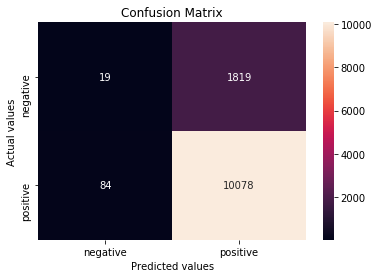

In [23]:
#Confusion Matrix
cm = confusion_matrix(y_test_bow, pred)

#Plotting confusion matrix
class_label = ["negative","positive"]
dataframe_cm = pd.DataFrame(cm, index=class_label, columns=class_label)
sns.heatmap(dataframe_cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.show()

In above confusion matrix tn(true negative)=19,tp(true positive)=10078,fn(false negative)=1819,fp(false positive)=84.As it is shown in classification report overall occuracy(correctly classified points)=(tp+tn)/total=(10078+19)/12000 = ~84% overall error rate/misclassification rate=(fn+fp)/total=(1819+84)/12000 = ~15%

In [24]:
#Classification report
print("classification report:")
print("**********************")
print(classification_report(y_test_bow,pred))

classification report:
**********************
             precision    recall  f1-score   support

          0       0.18      0.01      0.02      1838
          1       0.85      0.99      0.91     10162

avg / total       0.75      0.84      0.78     12000



Observed that the accuracy for KNN model with bag of words is 84%

# Feature generation techniques to convert text to vector
Applying KNN with TF-IDF

In [25]:
#splitting data into train and test where 70% data used for train model and 30% for test model
X = final_40k['CleanedText']
print("shape of X:",X.shape)
y = final_40k['Score']
print("shape of y:",y.shape)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X,y,test_size=0.3,random_state=0)
print(X_train_tfidf.shape, y_train_tfidf.shape, X_test_tfidf.shape)

shape of X: (40000,)
shape of y: (40000,)
(28000,) (28000,) (12000,)


In [26]:
#TF-IDF train data
tfidf_vect = TfidfVectorizer()
X_train_tfidf=tfidf_vect.fit_transform(X_train_tfidf)
print("the type of tfidf vectorier",type(X_train_tfidf))
print("the shape of tfidf vetorizer",X_train_tfidf.get_shape()) 

the type of tfidf vectorier <class 'scipy.sparse.csr.csr_matrix'>
the shape of tfidf vetorizer (28000, 20953)


In [27]:
#TF-IDF test data 
tfidf_vect = TfidfVectorizer()
X_test_tfidf=tfidf_vect.fit_transform(X_test_tfidf)
print("the type of tfidf vectorier",type(X_test_tfidf))
print("the shape of tfidf vetorizer",X_test_tfidf.get_shape()) 

the type of tfidf vectorier <class 'scipy.sparse.csr.csr_matrix'>
the shape of tfidf vetorizer (12000, 14326)


In [28]:
from sklearn.decomposition import TruncatedSVD

svd_model=TruncatedSVD(algorithm='randomized', n_components=300, n_iter=5, random_state=0, tol=0.0)
X_train_tfidf_trun = svd_model.fit_transform(X_train_tfidf)
print(svd_model.explained_variance_ratio_.sum())
X_test_tfidf_trun = svd_model.fit_transform(X_test_tfidf)
print(svd_model.explained_variance_ratio_.sum())

0.39073959501988553
0.4059777522513171


In [29]:
%%time
#performing simple cross validation method
#creating odd list of K for NN
for i in range(1,30,2):
    #instantiate learning model(k=30)
    knn = KNeighborsClassifier(n_neighbors=i, algorithm="kd_tree")
    
    #fitting the model on cross validation train
    knn.fit(X_train_tfidf_trun, y_train_tfidf)
    
    #predict the response on the cross validation train
    pred = knn.predict(X_test_tfidf_trun)
    
    #evaluate CV accuracy
    acc = accuracy_score(y_test_tfidf, pred, normalize=True)*float(100)
    print("\nCV accuracy for k = %d is %d%%" %(i,acc))
    


CV accuracy for k = 1 is 67%

CV accuracy for k = 3 is 74%

CV accuracy for k = 5 is 77%

CV accuracy for k = 7 is 79%

CV accuracy for k = 9 is 80%

CV accuracy for k = 11 is 81%

CV accuracy for k = 13 is 82%

CV accuracy for k = 15 is 82%

CV accuracy for k = 17 is 83%

CV accuracy for k = 19 is 83%

CV accuracy for k = 21 is 83%

CV accuracy for k = 23 is 83%

CV accuracy for k = 25 is 83%

CV accuracy for k = 27 is 83%

CV accuracy for k = 29 is 83%
Wall time: 1h 17min


In [30]:
%%time
#Accuracy on train data
traintfidf_acc_score = knn.score(X_train_tfidf_trun,y_train_tfidf)
print("Train accuracy",traintfidf_acc_score)

#Error on Train data
traintfidf_error = 1-(traintfidf_acc_score)
print("Train error ",traintfidf_error)

Train accuracy 0.858
Train error  0.14200000000000002
Wall time: 12min 49s


In [31]:
#Evaluate accuracy on test data
testtfidf_accuracy = accuracy_score(y_test_tfidf, pred) 
print("Accuracy for KNN model with tfidf is", round(testtfidf_accuracy,3))

Accuracy for KNN model with tfidf is 0.839


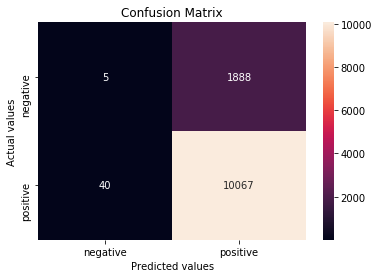

In [32]:
#Confusion Matrix
cm = confusion_matrix(y_test_tfidf, pred)

#Plotting confusion matrix
class_label = ["negative","positive"]
dataframe_cm = pd.DataFrame(cm, index=class_label, columns=class_label)
sns.heatmap(dataframe_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.show()

In above confusion matrix tn(true negative)=5,tp(true positive)=10067,fn(false negative)=1888,fp(false positive)=40.As it is shown in classification report overall occuracy(correctly classified points)=(tp+tn)/total=(10067+5)/12000 = ~83% overall error rate/misclassification rate=(fn+fp)/total=(1888+40)/12000 = ~16%

In [33]:
#Classification report
print("classification report:")
print("**********************")
print(classification_report(y_test_tfidf,pred))

classification report:
**********************
             precision    recall  f1-score   support

          0       0.11      0.00      0.01      1893
          1       0.84      1.00      0.91     10107

avg / total       0.73      0.84      0.77     12000



Observed that the accuracy for KNN model with TF-IDF is 83%

# Feature generation techniques to convert text to vector
Applying KNN with TF-IDF Average Word2vec

In [34]:
#splitting data into train and test where 70% data used for train model and 30% for test model
X = final_40k['CleanedText']
print("shape of X:",X.shape)
y = final_40k['Score']
print("shape of y:",y.shape)
X_train_avgw2v, X_test_avgw2v, y_train_avgw2v, y_test_avgw2v = train_test_split(X,y,test_size=0.3,random_state=0)
print(X_train_avgw2v.shape, y_train_avgw2v.shape, X_test_avgw2v.shape)

shape of X: (40000,)
shape of y: (40000,)
(28000,) (28000,) (12000,)


In [35]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

#Train your own word2vec model using your own text corpus of train data
import gensim
i=0
list_of_sent_train=[]
for sent in X_train_avgw2v:
    list_of_sent_train.append(sent.split())
print(list_of_sent_train[0])
print('**********************************')
print(list_of_sent_train[1])

['receiv', 'nifti', 'coffe', 'pod', 'drawer', 'could', 'wait', 'use', 'love', 'black', 'mesh', 'design', 'sturdi', 'chrome', 'carousel', 'nice', 'held', 'drawer', 'hold', 'separ', 'tea', 'flavor', 'coffe', 'coffe', 'also', 'small', 'enough', 'foot', 'print', 'sit', 'next', 'keurig', 'would', 'recommend', 'drawer', 'anyon']
**********************************
['ive', 'tast', 'brand', 'flax', 'milk', 'brand', 'best', 'far', 'creami', 'brand', 'realli', 'creami', 'slight', 'tast', 'littl', 'nutti', 'guess', 'cant', 'wait', 'order', 'amazon', 'hope', 'ship', 'reason']


In [36]:
#min_count=5 considers only the words occur atleast 5 times
w2v_model=Word2Vec(list_of_sent_train,min_count=5,size=50,workers=4)
words=list(w2v_model.wv.vocab)
print("number of words that occured 5 times",len(words))

number of words that occured 5 times 7248


In [37]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times",len(w2v_words))
print("sample words",w2v_words[0:50])

number of words that occured minimum 5 times 7248
sample words ['receiv', 'nifti', 'coffe', 'pod', 'drawer', 'could', 'wait', 'use', 'love', 'black', 'mesh', 'design', 'sturdi', 'carousel', 'nice', 'held', 'hold', 'separ', 'tea', 'flavor', 'also', 'small', 'enough', 'foot', 'print', 'sit', 'next', 'keurig', 'would', 'recommend', 'anyon', 'ive', 'tast', 'brand', 'flax', 'milk', 'best', 'far', 'creami', 'realli', 'slight', 'littl', 'nutti', 'guess', 'cant', 'order', 'amazon', 'hope', 'ship', 'reason']


In [38]:
#average word2vec
#compute average word2vec for each review
sent_vectors_train=[];# the avg-w2v for each sentence/review is stored
for sent in tqdm(list_of_sent_train): #for each review/sentence
    sent_vec=np.zeros(50) #as word vectors are of zero length
    cnt_words=0  #number of words with a valid vector in the review/sentence
    for word in sent: #for each word in a review/sentence
        if word in w2v_words:
            vec=w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|███████████████████████████████████| 28000/28000 [01:00<00:00, 464.60it/s]


28000
50


In [39]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

#Train your own word2vec model using your own text corpus of train data
import gensim
i=0
list_of_sent_test=[]
for sent in X_test_avgw2v:
    list_of_sent_test.append(sent.split())
print(list_of_sent_test[0])
print('**********************************')
print(list_of_sent_test[1])

['normal', 'dont', 'write', 'review', 'need', 'recours', 'sinc', 'eat', 'bag', 'bitter', 'stuff', 'bitter', 'refus', 'away', 'matter', 'long', 'wash', 'grain', 'quinoa', 'ive', 'eaten', 'past', 'dont', 'even', 'bother', 'wash', 'nutti', 'quinoa', 'flavor', 'love', 'entir', 'miss', 'dont', 'buy']
**********************************
['base', 'review', 'thought', 'give', 'wisconsin', 'chees', 'flavor', 'tri', 'mayb', 'tast', 'bud', 'get', 'old', 'much', 'tast', 'guess', 'could', 'alway', 'use', 'bait', 'mous', 'trap']


In [40]:
#min_count=5 considers only the words occur atleast 5 times
w2v_model=Word2Vec(list_of_sent_test,min_count=5,size=50,workers=4)
words=list(w2v_model.wv.vocab)
print("number of words that occured 5 times",len(words))

number of words that occured 5 times 4931


In [41]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times",len(w2v_words))
print("sample words",w2v_words[0:50])

number of words that occured minimum 5 times 4931
sample words ['normal', 'dont', 'write', 'review', 'need', 'sinc', 'eat', 'bag', 'bitter', 'stuff', 'refus', 'away', 'matter', 'long', 'wash', 'grain', 'quinoa', 'ive', 'eaten', 'past', 'even', 'bother', 'nutti', 'flavor', 'love', 'entir', 'miss', 'buy', 'base', 'thought', 'give', 'wisconsin', 'chees', 'tri', 'mayb', 'tast', 'bud', 'get', 'old', 'much', 'guess', 'could', 'alway', 'use', 'trap', 'new', 'name', 'product', 'friski', 'turkey']


In [42]:
#average word2vec
#compute average word2vec for each review
sent_vectors_test=[];# the avg-w2v for each sentence/review is stored
for sent in tqdm(list_of_sent_test): #for each review/sentence
    sent_vec=np.zeros(50) #as word vectors are of zero length
    cnt_words=0  #number of words with a valid vector in the review/sentence
    for word in sent: #for each word in a review/sentence
        if word in w2v_words:
            vec=w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████| 12000/12000 [00:22<00:00, 529.10it/s]


12000
50


In [43]:
len(sent_vectors_train)

28000

In [44]:
len(sent_vectors_test)

12000

In [45]:
%%time
X_train_avgw2v=sent_vectors_train
X_test_avgw2v=sent_vectors_test

#performing simple cross validation method
#creating odd list of K for NN
for i in range(1,30,2):
    #instantiate learning model(k=30)
    knn = KNeighborsClassifier(n_neighbors=i, algorithm="kd_tree")
    
    #fitting the model on cross validation train
    knn.fit(X_train_avgw2v, y_train_avgw2v)
    
    #predict the response on the cross validation train
    pred = knn.predict(X_test_avgw2v)
    
    #evaluate CV accuracy
    acc = accuracy_score(y_test_avgw2v, pred, normalize=True)*float(100)
    print("\nCV accuracy for k = %d is %d%%" %(i,acc))
    


CV accuracy for k = 1 is 74%

CV accuracy for k = 3 is 79%

CV accuracy for k = 5 is 81%

CV accuracy for k = 7 is 81%

CV accuracy for k = 9 is 82%

CV accuracy for k = 11 is 82%

CV accuracy for k = 13 is 82%

CV accuracy for k = 15 is 82%

CV accuracy for k = 17 is 83%

CV accuracy for k = 19 is 83%

CV accuracy for k = 21 is 83%

CV accuracy for k = 23 is 83%

CV accuracy for k = 25 is 83%

CV accuracy for k = 27 is 83%

CV accuracy for k = 29 is 83%
Wall time: 15min 4s


In [46]:
#Accuracy on train data
trainavgw2v_acc_score = knn.score(X_train_avgw2v,y_train_avgw2v)
print("Train accuracy",trainavgw2v_acc_score)

#Error on Train data
trainavgw2v_error = 1-(trainavgw2v_acc_score)
print("Train error ",trainavgw2v_error)

Train accuracy 0.8505714285714285
Train error  0.14942857142857147


In [47]:
#Evaluate accuracy on test data
testavgw2v_accuracy = accuracy_score(y_test_avgw2v, pred)
print("Accuracy for KNN model with Tfidf Average Word2vector is", round(testavgw2v_accuracy,3))

Accuracy for KNN model with Tfidf Average Word2vector is 0.836


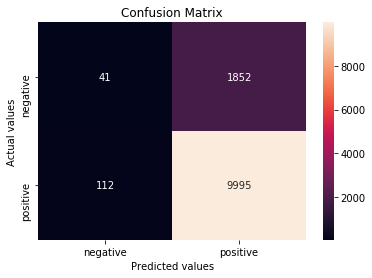

In [48]:
#Confusion Matrix
cm = confusion_matrix(y_test_avgw2v, pred)

#Plotting confusion matrix
class_label = ["negative","positive"]
dataframe_cm = pd.DataFrame(cm, index=class_label, columns=class_label)
sns.heatmap(dataframe_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.show()

In above confusion matrix tn(true negative)=41,tp(true positive)=9995,fn(false negative)=1852,fp(false positive)=112.As it is shown in classification report overall occuracy(correctly classified points)=(tp+tn)/total=(41+9995)/12000 = ~83% overall error rate/misclassification rate=(fn+fp)/total=(1852+112)/12000 = ~16%

In [49]:
#Classification report
print("classification report")
print("*********************")
print(classification_report(y_test_avgw2v,pred))

classification report
*********************
             precision    recall  f1-score   support

          0       0.27      0.02      0.04      1893
          1       0.84      0.99      0.91     10107

avg / total       0.75      0.84      0.77     12000



Observed that the accuracy for KNN model with TF-IDF Average Word2Vec is 84.4%

# Feature generation techniques to convert text to vector
Applying KNN with TF-IDF Weighted Word2vec

In [50]:
#splitting data into train and test where 70% data used for train model and 30% for test model
X = final_40k['CleanedText']
print("shape of X:",X.shape)
y = final_40k['Score']
print("shape of y:",y.shape)
X_train_wtdw2v, X_test_wtdw2v, y_train_wtdw2v, y_test_wtdw2v = train_test_split(X,y,test_size=0.3,random_state=0)
print(X_train_wtdw2v.shape, y_train_wtdw2v.shape, X_test_wtdw2v.shape)

shape of X: (40000,)
shape of y: (40000,)
(28000,) (28000,) (12000,)


In [51]:
model = TfidfVectorizer()
X_train_wtdw2v = model.fit_transform(X_train_wtdw2v)
#we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [52]:
model = TfidfVectorizer()
X_test_wtdw2v = model.fit_transform(X_test_wtdw2v)
#we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [53]:
#TF-IDF weighted word2vec
tfidf_feat=model.get_feature_names()
#tfidf words/col-names
#final_tf_idf is the sparse matrix with row=sentence,col=word and cell_val=tfidf
tfidf_sent_vectors_train=[]
row=0
for sent in tqdm(list_of_sent_train): #for each review/sentence
    sent_vec=np.zeros(50) #as word vectors are of zero length
    weight_sum=0  #num of words with a valid vector in the sentence/review
    for word in sent:   #for each word in a review/sentence
        if word in w2v_words:  
            vec=w2v_model.wv[word]#to reduce the computation we are
            tf_idf=dictionary[word]*(sent.count(word)/len(sent))#dictionary[word] = idf value of word in whole corpus
            sent_vec += (vec*tf_idf) #sent.count(word)= tf values of word in this review
            weight_sum += tf_idf
    if weight_sum !=0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row +=1
print(len(tfidf_sent_vectors_train))
print(len(tfidf_sent_vectors_train[0]))

100%|███████████████████████████████████| 28000/28000 [01:00<00:00, 464.16it/s]


28000
50


In [54]:
#TF-IDF weighted word2vec
tfidf_feat=model.get_feature_names()
#tfidf words/col-names
#final_tf_idf is the sparse matrix with row=sentence,col=word and cell_val=tfidf
tfidf_sent_vectors_test=[]
row=0
for sent in tqdm(list_of_sent_test): #for each review/sentence
    sent_vec=np.zeros(50) #as word vectors are of zero length
    weight_sum=0  #num of words with a valid vector in the sentence/review
    for word in sent:   #for each word in a review/sentence
        if word in w2v_words:  
            vec=w2v_model.wv[word]#to reduce the computation we are
            tf_idf=dictionary[word]*(sent.count(word)/len(sent))#dictionary[word] = idf value of word in whole corpus
            sent_vec += (vec*tf_idf) #sent.count(word)= tf values of word in this review
            weight_sum += tf_idf
    if weight_sum !=0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row +=1
print(len(tfidf_sent_vectors_test))
print(len(tfidf_sent_vectors_test[0]))

100%|███████████████████████████████████| 12000/12000 [00:27<00:00, 444.37it/s]


12000
50


In [55]:
%%time
X_train_wtdw2v=tfidf_sent_vectors_train
X_test_wtdw2v=tfidf_sent_vectors_test

#performing simple cross validation method
#creating odd list of K for NN
for i in range(1,30,2):
    #instantiate learning model(k=30)
    knn = KNeighborsClassifier(n_neighbors=i, algorithm="kd_tree")
    
    #fitting the model on cross validation train
    knn.fit(X_train_wtdw2v, y_train_wtdw2v)
    
    #predict the response on the cross validation train
    pred = knn.predict(X_test_wtdw2v)
    
    #evaluate CV accuracy
    acc = accuracy_score(y_test_wtdw2v, pred, normalize=True)*float(100)
    print("\nCV accuracy for k = %d is %d%%" %(i,acc))
    


CV accuracy for k = 1 is 79%

CV accuracy for k = 3 is 82%

CV accuracy for k = 5 is 84%

CV accuracy for k = 7 is 85%

CV accuracy for k = 9 is 85%

CV accuracy for k = 11 is 85%

CV accuracy for k = 13 is 85%

CV accuracy for k = 15 is 85%

CV accuracy for k = 17 is 85%

CV accuracy for k = 19 is 85%

CV accuracy for k = 21 is 85%

CV accuracy for k = 23 is 85%

CV accuracy for k = 25 is 85%

CV accuracy for k = 27 is 85%

CV accuracy for k = 29 is 85%
Wall time: 10min 5s


In [56]:
#Accuracy on train data
trainwtdw2v_acc_score = knn.score(X_train_wtdw2v,y_train_wtdw2v)
print("Train accuracy",trainwtdw2v_acc_score)

#Error on Train data
trainwtdw2v_error = 1-(trainwtdw2v_acc_score)
print("Train error ",trainwtdw2v_error)

Train accuracy 0.8586428571428572
Train error  0.14135714285714285


In [57]:
#Evaluate accuracy on test data
testwtdw2v_accuracy = accuracy_score(y_test_wtdw2v, pred)
print("Accuracy for KNN model with Tfidf Weighted Word2vector is", round(testwtdw2v_accuracy,3))

Accuracy for KNN model with Tfidf Weighted Word2vector is 0.853


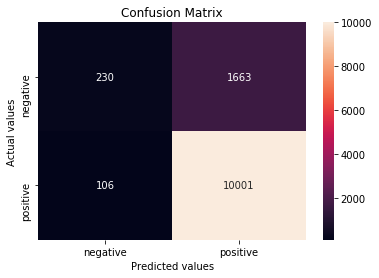

In [58]:
#Confusion Matrix
cm = confusion_matrix(y_test_wtdw2v, pred)

#Plotting confusion matrix
class_label = ["negative","positive"]
dataframe_cm = pd.DataFrame(cm, index=class_label, columns=class_label)
sns.heatmap(dataframe_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.show()

In above confusion matrix tn(true negative)=230,tp(true positive)=10001,fn(false negative)=1663,fp(false positive)=106.As it is shown in classification report overall occuracy(correctly classified points)=(tp+tn)/total=(10001+230)/12000 = ~85% overall error rate/misclassification rate=(fn+fp)/total=(1663+106)/12000 = ~14%

In [59]:
#Classification report
print("classification report")
print("*********************")
print(classification_report(y_test_wtdw2v,pred))

classification report
*********************
             precision    recall  f1-score   support

          0       0.68      0.12      0.21      1893
          1       0.86      0.99      0.92     10107

avg / total       0.83      0.85      0.81     12000



Observed that the accuracy for KNN model with TF-IDF Weighted Word2vec is 85%

In [60]:
from prettytable import PrettyTable
x = PrettyTable()
x.add_column("Vectorizer",["Bag Of Words","TF-IDF","Average Word2vec","TF-IDF Weighted Word2vec"])
x.add_column("Model",['Kd-tree','Kd-tree','Kd-tree','Kd-tree'])
x.add_column("Accuracy on Test Data",[testbow_accuracy,testtfidf_accuracy,testavgw2v_accuracy,testwtdw2v_accuracy])
print(x)

+--------------------------+---------+-----------------------+
|        Vectorizer        |  Model  | Accuracy on Test Data |
+--------------------------+---------+-----------------------+
|       Bag Of Words       | Kd-tree |   0.8414166666666667  |
|          TF-IDF          | Kd-tree |   0.8393333333333334  |
|     Average Word2vec     | Kd-tree |   0.8363333333333334  |
| TF-IDF Weighted Word2vec | Kd-tree |   0.8525833333333334  |
+--------------------------+---------+-----------------------+


Observation: By comparing the accuracy of all the four feature generation techniques KNN model with TF-IDF Weighted Word2vec gives 85% of accuracy, which is the best accuracy to predict the polarity of reviews among all the models.